In [111]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [112]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [113]:
def gaussScore(x0,temp,nSteps,dt,device = "cpu"):
    x0 = torch.from_numpy(x0).to(torch.float32).to(device)
    N = x0.shape[1]
    W = torch.Tensor(nSteps+1,N,N)
    #b = torch.Tensor(nSteps+1,N)
    cov = torch.cov(x0.T)
    m0 = torch.mean(x0,dim=1)
    for i in range(nSteps+1):
        exp_t = torch.exp(torch.Tensor([-2*(i+1)*dt]))
        exp_tsq = exp_t*exp_t
        W[i] = torch.linalg.inv(temp[i]*(1-exp_tsq)*torch.eye(N) + exp_tsq*cov)
        #b[i] = -exp_t* torch.mm(W[i],m0)
    return W


In [136]:
L = 14
N = L**2
P = 100000
temp = np.linspace(0.25,0.25,301)
x0 = load_data(L,2.27,200000)
sel = np.random.choice(range(200000),P,replace = False)
W = gaussScore(x0[sel],temp,300,0.02)

In [137]:
def backward(xT,W,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps+1,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    for tt in range(nSteps+1)[::-1]:
        std = np.sqrt(2*temp[tt]*dt)*torch.randn_like(xT)

        for n in range(nbatches):
            if(full_traj):
                score = -torch.matmul(x_recon[n*batch_size:(n+1)*batch_size,tt,:],W[tt])
                x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp[tt]*score*dt + std[n*batch_size:(n+1)*batch_size]
            else:
                score = -torch.matmul(x_recon[n*batch_size:(n+1)*batch_size],W[tt])
                x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp[tt]*score*dt + std[n*batch_size:(n+1)*batch_size]
            del score
    
    return x_recon

In [138]:
xT = np.sqrt(temp[-1])*torch.randn((P,N))
x_recon = backward(xT,W,temp,300,0.02).numpy()

(array([0.00000000e+00, 0.00000000e+00, 1.82608756e-04, 1.64347791e-03,
        8.21738956e-03, 4.51043505e-02, 1.76673924e-01, 5.17695683e-01,
        1.10624354e+00, 1.69935639e+00, 1.99618694e+00, 1.70985639e+00,
        1.10551311e+00, 5.22626118e-01, 1.84982620e-01, 4.31869591e-02,
        1.07739108e-02, 2.09999955e-03, 9.13043781e-05, 0.00000000e+00,
        0.00000000e+00]),
 array([-1.14999998, -1.0404762 , -0.93095237, -0.8214286 , -0.71190476,
        -0.60238093, -0.49285713, -0.38333333, -0.27380952, -0.16428572,
        -0.05476191,  0.05476191,  0.16428572,  0.27380952,  0.38333333,
         0.49285713,  0.60238093,  0.71190476,  0.8214286 ,  0.93095237,
         1.0404762 ,  1.14999998]),
 <BarContainer object of 21 artists>)

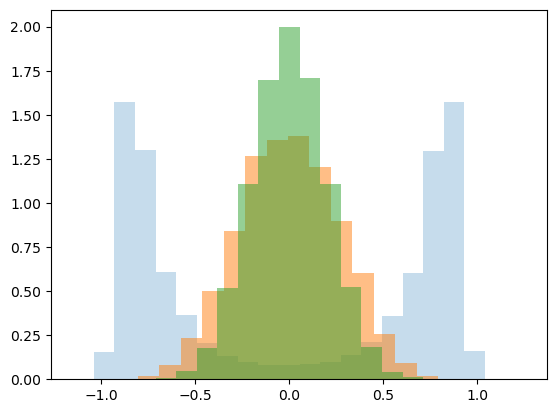

In [139]:
plt.hist(np.mean(x0,axis = 1),bins = 21,range=(-1.15,1.15),alpha = 0.25,density=  True)
plt.hist(np.mean(np.sign(x_recon),axis=1),bins = 21,range=(-1.15,1.25),alpha = 0.5,density=  True)
plt.hist(np.mean(x_recon,axis=1),bins = 21,range=(-1.15,1.15),alpha = 0.5,density=  True)

In [140]:
def Dkl(x0,x_recon):
    eps = 1e-05
    c1,tmp = np.histogram(np.mean(x0,axis = 1),bins = 21,range=(-1.25,1.25),density = True)
    c2,tmp = np.histogram(np.mean(x_recon,axis = 1),bins = 21,range=(-1.25,1.25),density = True)
    return np.sum(c1*np.log((c1+eps)/(c2+eps)))

In [141]:
Dkl(x0[sel],x_recon)

50.488971666790995

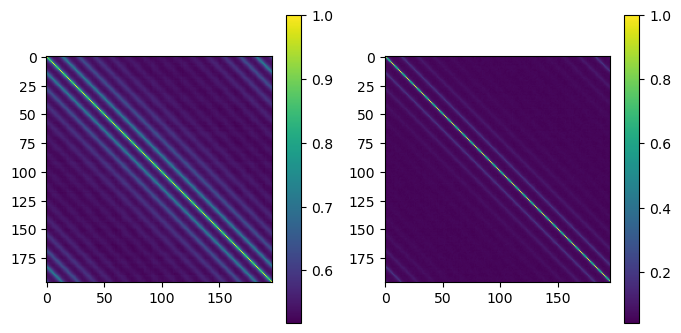

In [142]:
cov1 = np.cov(x0[sel].T)
cov2 = np.cov(np.sign(x_recon.T))
cov3 = np.cov(x_recon.T)
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.imshow(cov1)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(cov2)
plt.colorbar()

In [143]:
np.sum((cov1-cov2)**2)/np.sum(cov1**2)

0.7651287239235711

In [144]:
np.sum((cov1-cov3)**2)/np.sum(cov1**2)

0.8606848266596187